In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine, inspect

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sqlalchemy import func, distinct

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [27]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [30]:
from datetime import datetime, timedelta

In [31]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [32]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [33]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
# Find the most recent date in the data set in the measurement table.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [35]:
# Now, finding the single most_recent_date in the measurement table
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d').date()
most_recent_date

datetime.date(2017, 8, 23)

In [36]:
# Calculate the date one year from the last date in the data set
one_year_ago = most_recent_date - timedelta(days=365)
one_year_ago


datetime.date(2016, 8, 23)

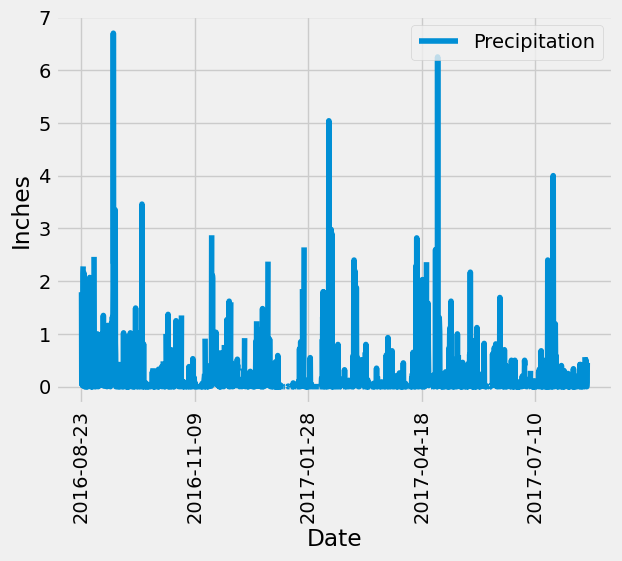

In [37]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and sort by date
measurement_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
measurement_df = measurement_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot('Date', 'Precipitation', label='Precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper right")
plt.show()

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_precipitation = measurement_df["Precipitation"].describe()
summary_precipitation_data =pd.DataFrame(summary_precipitation)
summary_precipitation_data

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(measurement.station))).all()  
print(total_stations)


[(9,)]


In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement.station, 
    func.count(measurement.station).label('count')
).group_by(
    measurement.station
).order_by(
    func.count(measurement.station).desc()
).all()

# List comprehension solution
most_active_stations_list = [(result[0],result[1]) for result in most_active_stations]
most_active_stations_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Creating a DataFrame with specified column names to understand the dataset
most_active_stations_data = pd.DataFrame(most_active_stations_list, columns=["Station Id", "Total Counts"])
most_active_stations_data

,Station Id,Total Counts
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
# Query to find the lowest, highest, and average temperature of the most active station
most_active_station_id = 'USC00519281'
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(
    measurement.station == most_active_station_id
).one()

#lowest_temp, highest_temp, avg_temp = temperature_stats
# printing the output in the list

most_active_stations_list = [(temperature_stats[0],temperature_stats[1],temperature_stats[2])]
most_active_stations_list

[(54.0, 85.0, 71.66378066378067)]

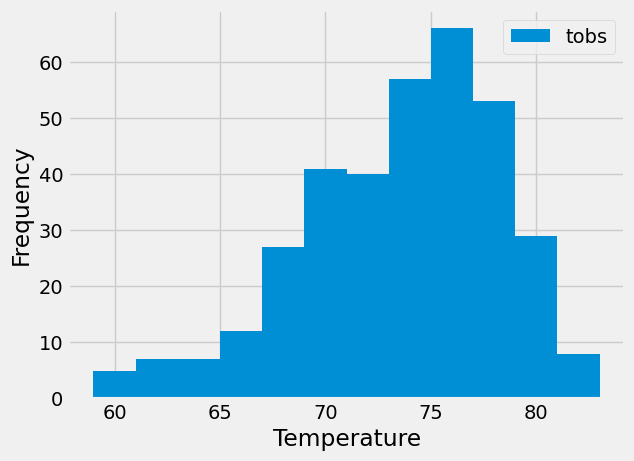

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'
temp_observation = session.query(measurement.tobs).filter(measurement.station ==most_active_station_id)\
      .filter(measurement.date >= one_year_ago).all()
temp_observation 

# Extracting temperature values from the query result
temperatures = [temp[0] for temp in temp_observation]

# Plotting the histogram
plt.hist(temperatures, bins=12,label = "tobs")  # You can adjust the number of bins as needed
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc= "upper right")
plt.show()

# Close Session

In [23]:
# Close Session
session.close()